### Measurement exploratory data analysis

In [2]:
DEVICES = [
    'custom',
    'beaglebone-fan',
    'beaglebone-compressor',
    'beaglebone-pump',
    'beaglebone-refrigerator',
    'steval-fan',
    'mafaulda-a',
    'mafaulda-b'
]

DEVICE = DEVICES[5]
T_WAVEFORM = 5  # (1 = MaufaulDa, 5 = others)
T_SEC = T_WAVEFORM
NFFT = 2**14 # (2**10 = others , 2**14 = MaufaulDa)
F_LIMIT = 3000 # (3000 = MaufaulDa/Steval, None = others)

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from tabulate import tabulate
from IPython.display import Markdown, HTML
from tqdm.notebook import tqdm

from typing import List, Tuple
import scipy
from scipy.signal import find_peaks, butter, sosfilt, lfilter, windows
from tsfel.feature_extraction.features import fundamental_frequency
from tsfel import feature_extraction as ft

from zipfile import ZipFile
import sys
sys.path.append('../')
from vibrodiagnostics import mafaulda, selection, discovery, models


def beaglebone_measurement(filename: str, fs: int) -> Tuple[str, pd.DataFrame]:
    g = 9.81
    milivolts = 1800
    resolution = 2**12
    columns = ['x', 'y', 'z']
    ts = pd.read_csv(filename, delimiter='\t', index_col=False, header=None, names=columns)
        
    # Calculate amplitude in m/s^2 Beaglebone Black ADC and ADXL335 resolution (VIN 1.8V, 12bits)
    for dim in columns:
        ts[dim] = ts[dim] * (milivolts / resolution)  # ADC to mV
        ts[dim] = (ts[dim] / 180) * g                 # mV to m/s^2 (180 mV/g)
        ts[dim] -= ts[dim].mean()

    ts['t'] = ts.index * (1 / fs)
    ts.set_index('t', inplace=True)
    return (os.path.basename(filename), ts, fs, ts.columns)  # last is feature columns


def beaglebone_dataset(filenames: List[str], fs: int) -> List[Tuple[str, pd.DataFrame]]:
    dataset = []
    for filename in filenames:
        name, ts, fs, cols = beaglebone_measurement(filename, fs)
        dataset.append((name, ts))
    return dataset


def steval_measurement(filename: str, fs: int) -> Tuple[str, pd.DataFrame]:
    columns = ['x', 'y', 'z']
    ts = pd.read_csv(filename, delimiter='\t', index_col=False, header=0, names=columns)
    for dim in columns:
        ts[dim] -= ts[dim].mean()
        # mg to m/s^2
        g = 9.81
        ts[dim] = g * (ts[dim] / 1000)
        # TODO: LSB to m/s^2

    ts['t'] = ts.index * (1 / fs)
    ts.set_index('t', inplace=True)
    return (os.path.basename(filename), ts, fs, ts.columns)


def steval_dataset(filenames: List[str], fs: int) -> List[Tuple[str, pd.DataFrame]]:
    dataset = []
    for filename in filenames:
        name, ts, fs, cols = steval_measurement(filename, fs)
        dataset.append((name, ts))
    return dataset


def lowpass_filter(data, cutpoint, fs, order=5):
    sos = butter(order, cutpoint, fs=fs, btype='lowpass', output='sos')
    y = sosfilt(sos, data)
    return y


def mafaulda_dataset(
        place,
        features_path =  '../../datasets/features_data/',
        mafaulda_path='../../datasets/MAFAULDA.zip',
        rpm=2500,
        lowpass_hz=10000):

    metadata_filename = os.path.join(features_path, selection.MAFAULDA_METADATA)
    faults = {
        'A': {
            'normal': 'normal',
            'imbalance': 'imbalance',
            'horizontal-misalignment': 'misalignment',
            'vertical-misalignment': 'misalignment',
            'underhang-outer_race': 'outer race fault',
            'underhang-cage_fault': 'cage fault',
            'underhang-ball_fault': 'ball fault'
        },
        'B': {
            'normal': 'normal',
            'imbalance': 'imbalance',
            'horizontal-misalignment': 'misalignment',
            'vertical-misalignment': 'misalignment',
            'overhang-cage_fault': 'cage fault',
            'overhang-ball_fault': 'ball fault',
            'overhang-outer_race': 'outer race fault'
        }
    }
    bearings = {
        'A': ['ax', 'ay', 'az'],
        'B': ['bx', 'by', 'bz']
    }

    metadata = pd.read_csv(metadata_filename, index_col='filename')
    metadata.reset_index(inplace=True)
    # print(len(metadata))
    metadata = metadata[metadata['fault'].isin(tuple(faults[place]))]
    metadata = models.fault_labeling(metadata, faults[place])
    print(len(metadata))
    files = pd.DataFrame()
    # Worst severity and mid rpm
    for name, group in metadata[(metadata['rpm'] >= rpm)].groupby(by='fault', observed=False):
        files = pd.concat([
            files,
            group[
                group['severity_level'] == group['severity_level'].max()
            ].sort_values(by='rpm', ascending=True).head(1)
        ])
    # print(len(files))
    ordering = {
        'normal': 0,
        'misalignment': 1,
        'imbalance': 2,
        'cage fault': 3,
        'ball fault': 4,
        'outer race fault': 5,
    }
    source = ZipFile(mafaulda_path)
    dataset = len(files) * [0]
    for index, file in files.iterrows():
        ts = mafaulda.csv_import(source, file['filename'])
        ts = ts[bearings[place]]
        ts.columns = ts.columns.str.extract(r'(\w)$')[0]
        for axis in ts.columns:
            ts[axis] = lowpass_filter(ts[axis], lowpass_hz, file['fs'])
        pos = ordering[file['fault']]
        dataset[pos] = ((file['fault'] + ' (' + file['filename'] +')', ts))

    return dataset

Load dataset

array([<Axes: xlabel='t'>, <Axes: xlabel='t'>, <Axes: xlabel='t'>],
      dtype=object)

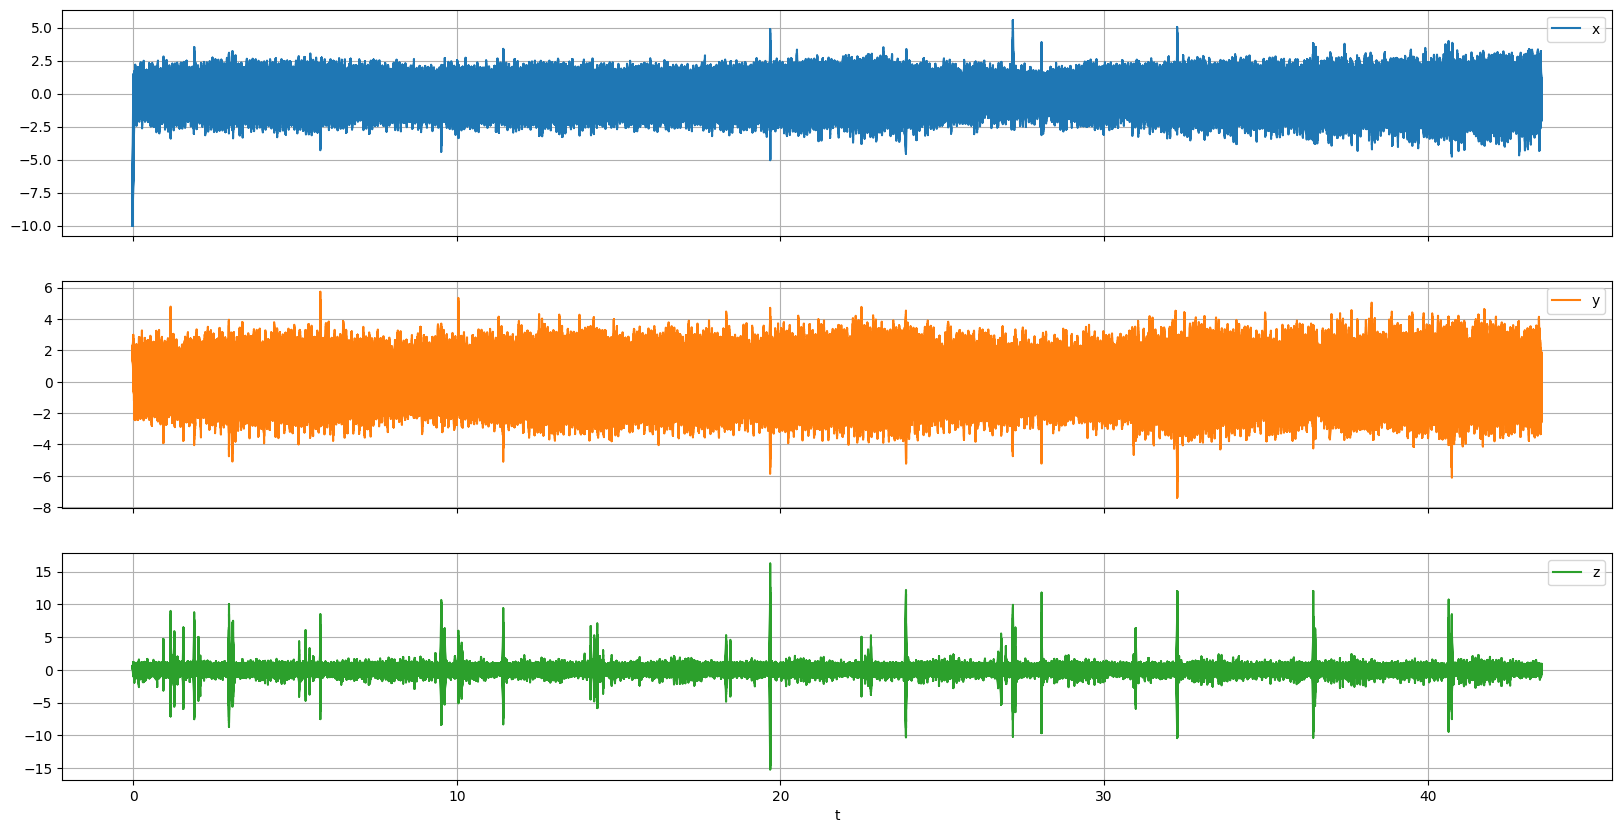

In [18]:
if DEVICE == 'custom':
    Fs = 2500
    files = {
        '../../inspections/fan/3_still.tsv': 'Fan speed fastest',
        '../../inspections/datacentres/shc3/k3_1.tsv': 'Scroll compressor worse',
        '../../inspections/datacentres/shc3/k5_1.tsv': 'Scroll compressor better',
        '../../inspections/pump-station/trials/bvs_1_hore.tsv': 'Water pump outer bearing',
        '../../inspections/pump-station/trials/bvs_3_motor.tsv': 'Electric motor for pump'
    }
    DATASET = beaglebone_dataset(files.keys(), Fs)
    DATASET = [(k, v[1]) for k, v in zip(files.values(), DATASET)]

elif DEVICE == 'beaglebone-fan':
    Fs = 2500
    path = '../../inspections/fan/'
    files = [
        '1_still.tsv', '2_still.tsv', '3_still.tsv',
        '1_up.tsv', '2_up.tsv', '3_up.tsv',
        '1_down.tsv', '2_down.tsv', '3_down.tsv'
    ]
    files = [os.path.join(path, name) for name in files]
    DATASET = beaglebone_dataset(files, Fs)

elif DEVICE == 'beaglebone-compressor':
    Fs = 2500
    path = '../../inspections/datacentres/shc3/'
    files = [
        'k3_1.tsv', 'k3_2.tsv', 'k3_3.tsv', 'k3_4.tsv',
        'k5_1.tsv', 'k5_2.tsv', 'k5_3.tsv', 'k5_4.tsv'
    ]
    files = [os.path.join(path, name) for name in files]
    DATASET = beaglebone_dataset(files, Fs)

elif DEVICE == 'beaglebone-pump':
    Fs = 2500
    path = '../../inspections/pump-station/trails/'
    files = [
        'bvs_1_hore.tsv', 'bvs_2_hore.tsv' 
        #, 'bvs_3_motor.tsv', 'bvs_4_motor.tsv'
    ]    
    files = [os.path.join(path, name) for name in files]
    DATASET = beaglebone_dataset(files, Fs)

elif DEVICE == 'beaglebone-refrigerator':
    Fs = 2500
    path = '../../inspections/home-refrigerator/'
    files = [
        'ch1.tsv', 'ch2.tsv', 'ch3.tsv', 'ch4.tsv', 'ch5.tsv'
    ]    
    files = [os.path.join(path, name) for name in files]
    DATASET = beaglebone_dataset(files, Fs)

elif DEVICE == 'steval-fan':
    #Fs = 26667
    path = '../../inspections/steval/'
    files = ['9.tsv', 'speed1.tsv', 'speed3.tsv', 'speedup.tsv']   # min-len=2  
    files = [os.path.join(path, name) for name in files]
    #DATASET = steval_dataset(files, Fs)

    g = 9.81
    columns = ['t', 'x', 'y', 'z']
    filename = files[0]
    ts = pd.read_csv(filename, delimiter='\t', index_col=False, header=0, names=columns)
    base = ts.head(1)['t'].values[0]
    ts['t'] -= base
    for dim in ['x', 'y', 'z']:
        ts[dim] -= ts[dim].mean()
        ts[dim] = g * (ts[dim] / 1000)
    ts['t'] /= 1000000000  # ns to s
    ts.set_index('t', inplace=True)
    #ts.index *= 3
    #ts['lag'] = ts.index - ts['t']  # negative lag is bad (samples are dropped)
    DATASET = ts

elif DEVICE == 'mafaulda-a':
    Fs = mafaulda.FS_HZ
    DATASET = mafaulda_dataset(place='A')

elif DEVICE == 'mafaulda-b':
    Fs = mafaulda.FS_HZ
    DATASET = mafaulda_dataset(place='B')

# Dropped samples
#DATASET[DATASET['lag'] < 0]
#DATASET.to_csv('result-dropped.csv')
DATASET[['x', 'y', 'z']].plot(subplots=True, grid=True, figsize=(20, 10))
# Plot fs over time

In [19]:
for name, ts in DATASET:
    display(Markdown(f'**{name}**'))
    ts.info()
    print()

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
for name, ts in DATASET:
    display(Markdown(f'**{name}**'))
    display(tabulate(ts.describe(), headers='keys', tablefmt='html'))
    ts.boxplot(grid=True)
    plt.show()

Statistical tests
- Normality test: Kolmogorov–Smirnov test
- Normality visual test: Quantile-quantile plot on chosen recording
- Stationarity test: Augmented Dickey–Fuller test
- Stationarity visual test: Autocorrelation plot

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import qqplot
from scipy.stats import kstest, shapiro

normality_tests = []
for name, ts in DATASET:
    for x in ts.columns:
        observations = ts[x].loc[T_WAVEFORM:T_WAVEFORM+0.5].to_numpy()[::10]
        #plt.plot(np.arange(0, len(observations)), observations)
        stat, p_value = shapiro(observations)
        print(name, p_value)
        test = {'name': name, 'axis': x, 'p-value': p_value, 'not-normal': p_value < 0.05}
        normality_tests.append(test)

normality_tests = pd.DataFrame.from_records(normality_tests)
print(normality_tests.value_counts('not-normal'))
normality_tests.describe()

In [ ]:
name, ts = DATASET[0]
fig, ax = plt.subplots(1, len(ts.columns), figsize=(10, 4))
for i, x in enumerate(ts.columns):
    qqplot(ts[x], line='45', ax=ax[i], marker='.', alpha=0.5)
    ax[i].set_title(f'Axis: {x}')

plt.tight_layout()
print(name)
plt.show()

In [ ]:
stationarity_tests = []
for name, ts in tqdm(DATASET):
    for x in ts.columns:
        observations = ts[x].loc[T_WAVEFORM:T_WAVEFORM+0.5].to_numpy()[::10]
        result = adfuller(observations)
        p_value = result[1]
        test = {
            'name': name,
            'axis': x,
            'statistic': result[0],
            'p-value': p_value,
            'stationary': p_value < 0.001
        }
        stationarity_tests.append(test)

stationarity_tests = pd.DataFrame.from_records(stationarity_tests)
print(stationarity_tests.value_counts('stationary'))
stationarity_tests['p-value'].describe()

In [ ]:
name, ts = DATASET[0]
fig, ax = plt.subplots(1, len(ts.columns), figsize=(10, 4))
for i, x in enumerate(ts.columns):
    ax[i].acorr(ts[x].iloc[0:1000], maxlags=100)
    ax[i].set_title(f'Axis: {x}')

plt.tight_layout()
print(name)
plt.show()

Time domain histogram

In [ ]:
for name, ts in DATASET:
    display(Markdown(f'**{name}**'))
    axis = ts.columns
    ax = ts[axis].hist(figsize=(15, 3), grid=True, bins=100, layout=(1, 3), edgecolor='black', linewidth=0.5)
    plt.show()

Time domain waveform

In [ ]:
for name, ts in DATASET:
    display(Markdown(f'**{name}**'))
    axis = ts.columns
    
    ax = ts[axis].plot(figsize=(20, 8), grid=True, subplots=True)
    for i, axname in enumerate(axis):
        ax[i].set_xlabel('Time [s]')
        ax[i].set_ylabel(f'Amplitude ({axname}) [m/s^2]')
    plt.show()               # plt.savefig('waveform.png')

Time domain waveform zoom detail

In [ ]:
for name, ts in DATASET:
    axis = ts.columns
    display(Markdown(f'**{name}**'))
    ax = (ts[axis].iloc[int(T_WAVEFORM*Fs):int(T_WAVEFORM*Fs)+Fs]
                  .plot(figsize=(20, 10), grid=True, subplots=True))
    
    for i, axname in enumerate(axis):
        ax[i].set_xlabel('Time [s]')
        ax[i].set_ylabel(f'Amplitude ({axname}) [m/s^2]')
    plt.show()      # plt.savefig('waveform_zoom.png')

Time domain waveform zoom - faults side by side

In [ ]:
fig, ax = plt.subplots(len(DATASET), 3, figsize=(12, 15))

for idx, df in enumerate(DATASET):
    name, ts = df
    columns = ts.columns
    ax[idx][1].set_title(name)
    ax[idx][0].set_ylabel('Amplitude [m/s\u00B2]')

    for pos, axis in enumerate(columns):
        data = ts[axis].loc[T_WAVEFORM:T_WAVEFORM+0.3]
        ax[idx][pos].plot(data.index, data, linewidth=1, color='darkblue')
        ax[idx][pos].set_xlabel('Time [s]')
        ax[idx][pos].grid()

plt.tight_layout()
plt.show()

#### Velocity of vibrations in time domain:
    - Detrend with mean of envelope
    - Interpolate envelope
    - Trapezoidal integration
    - https://stackoverflow.com/questions/61574495/scipy-detrend-in-python

In [ ]:
def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """

    # locals min      
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 
    
    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(s) 
        # pre-sorting of locals min based on relative position with respect to s_mid 
        lmin = lmin[s[lmin] < s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid 
        lmax = lmax[s[lmax] > s_mid]

    # global min of dmin-chunks of locals min 
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global max of dmax-chunks of locals max 
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    
    return lmin,lmax

def velocity_converter(t, a):
    velocity = scipy.integrate.cumulative_trapezoid(a, x=time) * 1000

    # Calculate envelope
    lmin, lmax = hl_envelopes_idx(velocity)
    env_min, env_max = velocity[lmin], velocity[lmax]

    # Interpolate the filled array
    env_min = scipy.interpolate.interp1d(lmin, velocity[lmin], kind='cubic', fill_value='extrapolate')(np.arange(0, len(velocity)))
    env_max = scipy.interpolate.interp1d(lmax, velocity[lmax], kind='cubic', fill_value='extrapolate')(np.arange(0, len(velocity)))
    mean_envelope = ((env_max + env_min) / 2)

    # Detrend with mean of envelope
    velocity -= mean_envelope
    # Graph velocity in mm/s
    return (t[:-1],  velocity)

In [ ]:
fig, ax = plt.subplots(len(DATASET), 3, figsize=(12, 15))
T_WAVEFORM = 1

for idx, df in enumerate(DATASET):
    name, ts = df
    columns = ts.columns
    ax[idx][1].set_title(name)
    ax[idx][0].set_ylabel('Velocity [mm/s]')

    for pos, axis in enumerate(columns):
        signal = ts[axis]
        time = signal.index
        t, v = velocity_converter(time, signal)

        velocity = pd.Series(v, index=t)
        data = velocity.loc[T_WAVEFORM:T_WAVEFORM+0.3]
        ax[idx][pos].plot(data.index, data, linewidth=1, color='darkblue')
        ax[idx][pos].set_xlabel('Time [s]')
        ax[idx][pos].grid()

plt.tight_layout()
plt.show()

In [ ]:
for name, ts in DATASET:
    display(Markdown(f'**{name}**'))
    axis = ts.columns
    
    fig, ax = plt.subplots(len(axis), 1, figsize=(20, 8))
    for i, axname in enumerate(axis):
        # Integrate acceleration to velocity
        signal = ts[axname]
        time = signal.index
        t, v = velocity_converter(time, signal)
        ax[i].plot(t,  v)

        ax[i].grid()
        ax[i].set_xlabel('Time [s]')
        ax[i].set_ylabel(f'Velocity ({axname}) [mm/s]')

        # Plot rms velocity 
        print('RMS velocity [mm/s]')
        print(f'\t{axname}: {ft.rms(velocity)}')
    plt.show()

In [ ]:
def spectogram(x, debug=True):
    fig, ax = plt.subplots(figsize=(15, 4))
    cmap = plt.get_cmap('inferno')
    pxx, freqs, t, im = plt.specgram(
        x, NFFT=NFFT, Fs=Fs,
        detrend='mean',
        mode='magnitude', scale='dB',
        cmap=cmap, vmin=-60
    )
    fig.colorbar(im, aspect=20, pad=0.04)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')
    mafaulda.resolution_calc(Fs, NFFT)
    return freqs, pxx


def window_idx(t):
    return (Fs * t) // NFFT + 1


def spectrum_slice(freqs, Pxx, t):
    fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    n = window_idx(t)

    dB = 20 * np.log10(Pxx.T[n] / 0.000001)
    ax[0].plot(freqs, dB)      # 1 dB = 1 um/s^2
    ax[0].grid(True)
    ax[0].set_xlabel('Frequency [Hz]')
    ax[0].set_ylabel('Amplitude [dB]')
    
    ax[1].plot(freqs, Pxx.T[n])
    ax[1].grid(True)
    ax[1].set_xlabel('Frequency [Hz]')
    ax[1].set_ylabel('Amplitude [m/s^2]')
    return n


def get_max_frequency(freqs, Pxx, i):
    max_freq = freqs[np.argmax(Pxx.T[i])]
    return max_freq


def get_peaks(freqs, Pxx, i, top=5):
    amplitudes = Pxx.T[i]
    peaks, _ = find_peaks(amplitudes, distance=3)

    fundamental = get_max_frequency(freqs, Pxx, i)
    f_top = freqs[peaks[np.argsort(amplitudes[peaks])]][::-top]
    y_top = np.sort(amplitudes[peaks])[::-top]

    return pd.DataFrame({
        'f': f_top,
        'y': y_top,
        '1x': f_top / fundamental 
    })


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    y = lfilter(b, a, data)
    return y


def get_spectrograms(DATASET: List[pd.DataFrame], axis: str) -> list:
    spectrograms = []

    for name, ts in DATASET:
        base_freq = fundamental_frequency(ts[axis], Fs)
        display(Markdown(f'**{name}** *({axis.upper()} axis, Fundamental = {base_freq:.4f} Hz)*'))
        
        freqs, Pxx = spectogram(ts[axis])
        spectrograms.append((name, freqs, Pxx))
        plt.show()          # plt.savefig(f'x_axis_fft_{NFFT}.png')
    
    return spectrograms


def show_spectrogram_detail(spectrograms: list, axis: str, t: float):
    for name, freqs, Pxx in spectrograms:
        display(Markdown(f'**{name}** ({axis.upper()} axis @ {t}s)'))
        i_window = spectrum_slice(freqs, Pxx, t)
        plt.show()           #plt.savefig(f'x_axis_fft_{NFFT}_at_{T_SEC}s.png')


def show_mms_peaks(spectrograms: list, axis: str, t: float):
    for name, freqs, Pxx in spectrograms:
        display(Markdown(f'**{name}** ({axis.upper()} axis @ {t}s)'))
    
        i_window = window_idx(t)
        peaks = discovery.mms_peak_finder(Pxx.T[i_window])
        
        fig, ax = plt.subplots(1, 1, figsize=(15, 3))
        ax.grid(True)
        ax.plot(freqs, Pxx.T[i_window])
        ax.scatter(freqs[peaks], Pxx.T[i_window][peaks], marker='^', color='red')
        ax.set_xlabel('Frequency [Hz]')
        
        plt.show()


def show_harmonic_series(spectrograms: list, axis: str, t: float):
    # https://stackoverflow.com/questions/1982770/changing-the-color-of-an-axis
    for name, freqs, Pxx in spectrograms:
        display(Markdown(f'**{name}** ({axis.upper()} axis @ {t}s)'))
    
        i_window = window_idx(t)
        h_series = discovery.harmonic_series_detection(freqs, Pxx.T[i_window], Fs, NFFT)
    
        # Find best (sum of harmonics' amplitudes in the largest)
        max_harmonic_amp_idx = np.argmax([
            sum([h[1] for h in s]) / len(s)
            for s in h_series
        ])
        best_harmonic_series = pd.DataFrame(
            h_series[max_harmonic_amp_idx],
            columns=['Frequency [Hz]', 'Amplitude [m/s^2]']
        )
        best_harmonic_series.index += 1
        display(tabulate(best_harmonic_series, headers='keys', tablefmt='html'))
    
        # Plot found harmonic series
        fig, ax = plt.subplots(1, 8, figsize=(30, 4))
        for i in range(8):
            s = h_series[i+1]
            if i == max_harmonic_amp_idx:
                ax[i].xaxis.label.set_color('red')
    
            ax[i].plot(freqs, Pxx.T[i_window])
            ax[i].scatter([x[0] for x in s], [x[1] for x in s], marker='^', color='red')
            ax[i].set_xlabel('Frequency [Hz]')
    
        plt.show()

def show_spectra_largest_amplitudes(spectrograms: list, axis: str, t: float):
    for name, freqs, Pxx in spectrograms:
        display(Markdown(f'**{name}** ({axis.upper()} axis @ {t}s)'))

        i_window = window_idx(t)
        x_fundamental = get_max_frequency(freqs, Pxx, i_window)
        peaks = get_peaks(freqs, Pxx, i_window)
        
        display(Markdown(f'- *Fundamental frequency:* {x_fundamental} Hz'))
        display(tabulate(peaks.head(5), headers='keys', tablefmt='html'))


def compare_limited_specrograms(spectrograms: list, axis: str, t: float, dB=False):
    fig, ax = plt.subplots(len(DATASET), 1, figsize=(20, 8))#, sharey=True)
    #fig, ax = plt.subplots(len(DATASET), 1, figsize=(20, 20))
    i = 0
    for name, ts in DATASET:
        signal = ts[axis].loc[t:t+NFFT/Fs].to_numpy()
        n = len(signal)
        pxx = np.abs(np.fft.rfft(signal * windows.hann(n)) / n)
        if dB is True:
            pxx = 20 * np.log10(pxx / 0.000001)  # 1 dB = 1 um/s^2    
        freqs = np.fft.fftfreq(n, d=1/Fs)[:len(pxx)]

        # Shapiro
        # stat, p_value_s = shapiro(signal[:3000])
        # result = adfuller(signal[:3000])
        # print(name, p_value_s, result[1])


        ax[i].plot(freqs, pxx, color='darkblue')
        ax[i].fill_between(freqs, pxx, color='lightblue', alpha=0.3)
        ax[i].grid(True)
        ax[i].set_xlabel('Frequency [Hz]')
        ax[i].set_ylabel('Amplitude [m/s\u00B2]')
        ax[i].set_xlim(0, F_LIMIT)
        # ax[i].set_ylim(40, 120)
        #ax[i].set_ylim(0, 0.1)
        ax[i].set_title(name)
        i += 1

    # for j, lim in enumerate([0.8, 0.4, 0.4, 0.05, 0.02]):
    #     ax[j].set_ylim(0, lim)


def spectrogram_energy_left_cumulative(spectrograms: list, axis: str, t: float):
    fig, ax = plt.subplots(len(DATASET), 1, figsize=(20, 20), sharey=True)
    i = 0
    for name, ts in DATASET:
        signal = ts[axis].loc[t:t+NFFT/Fs].to_numpy()
        n = len(signal)
        pxx = np.abs(np.fft.rfft(signal * windows.hann(n)) / n) 
        freqs = np.fft.fftfreq(n, d=1/Fs)[:len(pxx)]
        
        ax[i].plot(freqs, np.cumsum(pxx) / np.sum(pxx))
        ax[i].grid(True)
        ax[i].set_xlabel('Frequency [Hz]')
        ax[i].set_ylabel('Cumulative energy [%]')
        #ax[i].set_xlim(50, 100)
        ax[i].set_title(name)
        i += 1

Compare mafaulda faults

In [ ]:
compare_limited_specrograms(DATASET, 'x', T_SEC)
plt.tight_layout()
plt.show()

In [ ]:
compare_limited_specrograms(DATASET, 'y', T_SEC)
plt.tight_layout()
plt.show()

In [ ]:
compare_limited_specrograms(DATASET, 'z', T_SEC)
plt.tight_layout()
plt.show()

Compare cumulative sums

In [ ]:
spectrogram_energy_left_cumulative(DATASET, 'x', T_SEC)
plt.tight_layout()
plt.show()

In [ ]:
spectrogram_energy_left_cumulative(DATASET, 'y', T_SEC)
plt.tight_layout()
plt.show()

In [ ]:
spectrogram_energy_left_cumulative(DATASET, 'z', T_SEC)
plt.tight_layout()
plt.show()

Spectrogram in X axis

In [ ]:
x_spectra = get_spectrograms(DATASET, 'x')

Spectrogram detail in X axis

In [ ]:
show_spectrogram_detail(x_spectra, 'x', T_SEC)

Peaks in frequency spectrum in X axis
- MMS peak finder algorithm

In [ ]:
show_mms_peaks(x_spectra, 'x', T_SEC)

Harmonic series detection in X axis

In [ ]:
# show_harmonic_series(x_spectra, 'x', T_SEC)

In [ ]:
show_spectra_largest_amplitudes(x_spectra, 'x', T_SEC)

Spectrogram in Y axis

In [ ]:
y_spectra = get_spectrograms(DATASET, 'y')

Spectrogram detail in Y axis

In [ ]:
show_spectrogram_detail(y_spectra, 'y', T_SEC)

Peaks in frequency spectrum in Y axis

In [ ]:
show_mms_peaks(y_spectra, 'y', T_SEC)

Harmonic series detection in Y axis

In [ ]:
# show_harmonic_series(y_spectra, 'y', T_SEC)

In [ ]:
show_spectra_largest_amplitudes(y_spectra, 'y', T_SEC)

Spectrogram in Z axis

In [ ]:
z_spectra = get_spectrograms(DATASET, 'z')

Spectrogram detail in Z axis

In [ ]:
show_spectrogram_detail(z_spectra, 'z', T_SEC)

Peaks in frequency spectrum in Z axis

In [ ]:
show_mms_peaks(z_spectra, 'z', T_SEC)

Harmonic series detection in Z axis

In [ ]:
# show_harmonic_series(z_spectra, 'z', T_SEC)

In [ ]:
show_spectra_largest_amplitudes(z_spectra, 'z', T_SEC)

Histogram

In [ ]:
axis = ['x', 'y', 'z']
for name, ts in DATASET:
    display(Markdown(f'**{name}**'))
    ts[axis].hist(figsize=(10, 5), grid=True, bins=50)
    plt.show()

In [ ]:
axis = ['x', 'y', 'z']
for name, ts in DATASET:
    display(Markdown(f'**{name}**'))
    ts[axis].boxplot(figsize=(10, 5))
    plt.show()

Orbitals of all cross sections

In [ ]:
for name, ts in DATASET:
    display(Markdown(f'**{name}**'))
    fig, ax = plt.subplots(1, 3, figsize=(20, 4))

    for i, col in enumerate([('x', 'y'), ('x', 'z'), ('y', 'z')]):
        ax[i].scatter(ts[col[0]], ts[col[1]], s=1)
        ax[i].grid(True)
        ax[i].set_xlabel(col[0].upper())
        ax[i].set_ylabel(col[1].upper())
        ax[i].grid(True)
    plt.show()       # plt.savefig('orbitals.png')

Orbitals of 1x harmonic frequency

In [ ]:
x_spectra_by_name = {spec[0]: spec for spec in x_spectra}
y_spectra_by_name = {spec[0]: spec for spec in y_spectra}
z_spectra_by_name = {spec[0]: spec for spec in z_spectra}
t = T_SEC
space = 7

for name, ts in DATASET:
    display(Markdown(f'**{name}**'))
    fig, ax = plt.subplots(1, 3, figsize=(20, 4))

    name, freqs, Pxx = x_spectra_by_name[name]
    x_fundamental = get_max_frequency(freqs, Pxx, window_idx(t))
    name, freqs, Pxx = y_spectra_by_name[name]
    y_fundamental = get_max_frequency(freqs, Pxx, window_idx(t))

    name, freqs, Pxx = z_spectra_by_name[name]
    z_fundamental = get_max_frequency(freqs, Pxx, window_idx(t))

    try:
        ts['x_1x'] = butter_bandpass_filter(ts['x'], x_fundamental - space, x_fundamental + space, Fs)
        ts['y_1x'] = butter_bandpass_filter(ts['y'], y_fundamental - space, y_fundamental + space, Fs)
        ts['z_1x'] = butter_bandpass_filter(ts['z'], z_fundamental - space, z_fundamental + space, Fs)
    except ValueError:
        continue
    
    for i, col in enumerate([('x_1x', 'y_1x'), ('x_1x', 'z_1x'), ('y_1x', 'z_1x')]):
        ax[i].scatter(ts[col[0]], ts[col[1]], s=1)
        ax[i].grid(True)
        ax[i].set_xlabel(col[0].upper())
        ax[i].set_ylabel(col[1].upper())
        ax[i].grid(True)
    
    plt.show()       # plt.savefig('orbitals_1x.png')

In [ ]:
t = 1
space = 4

for name, ts in DATASET:
    display(Markdown(f'**{name}**'))

    name, freqs, Pxx = x_spectra_by_name[name]
    x_fundamental = get_max_frequency(freqs, Pxx, window_idx(t))
    name, freqs, Pxx = y_spectra_by_name[name]
    y_fundamental = get_max_frequency(freqs, Pxx, window_idx(t))

    name, freqs, Pxx = z_spectra_by_name[name]
    z_fundamental = get_max_frequency(freqs, Pxx, window_idx(t))

    try:
        x = butter_bandpass_filter(ts['x'], x_fundamental - space, x_fundamental + space, Fs)
        y = butter_bandpass_filter(ts['y'], y_fundamental - space, y_fundamental + space, Fs)
        z = butter_bandpass_filter(ts['z'], z_fundamental - space, z_fundamental + space, Fs)
    except ValueError:
        continue

    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(x, y, z, zdir='y', s=1, color='navy')
    xlim = 6
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-xlim, xlim)
    ax.set_zlim(-xlim, xlim)
    ax.zaxis.labelpad = -0.7
    plt.show()